In [169]:
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
import time
import pandas as pd
from selenium.webdriver.common.action_chains import ActionChains
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
import glassdoor_scraper as gs 
import pandas as pd 

df = gs.get_jobs('data engineer', 600, False)

df.to_csv('glassdoor_engineer_jobs.csv', index = False)

Progress: 0/600
Progress: 1/600
Progress: 2/600
Progress: 3/600
Progress: 4/600
Progress: 5/600
Progress: 6/600
Progress: 7/600
Progress: 8/600
Progress: 9/600
Progress: 10/600
Progress: 11/600
Progress: 12/600
Progress: 13/600
Progress: 14/600
Progress: 15/600
Progress: 16/600
Progress: 17/600
Progress: 18/600
Progress: 19/600
Progress: 20/600
Progress: 21/600
Progress: 22/600
Progress: 23/600
Progress: 24/600
Progress: 25/600
Progress: 26/600
Progress: 27/600
Progress: 28/600
Progress: 29/600
Progress: 30/600
Progress: 31/600
Progress: 32/600
Progress: 33/600
Progress: 34/600
Progress: 35/600
Progress: 36/600
Progress: 37/600
Progress: 38/600
Progress: 39/600
Progress: 40/600
Progress: 41/600
Progress: 42/600
Progress: 43/600
Progress: 44/600
Progress: 45/600
Progress: 46/600
Progress: 47/600
Progress: 48/600
Progress: 49/600
Progress: 50/600
Progress: 51/600
Progress: 52/600
Progress: 53/600
Progress: 54/600
Progress: 55/600
Progress: 56/600
Progress: 57/600
Progress: 58/600
Progres

Merging data, removing duplicates, removing unwanted columns

In [7]:
df_engineer = pd.read_csv('engineer_jobs-450.csv', index_col = 0)
df_analyst = pd.read_csv('glassdoor_analyst_jobs.csv')
df_scientist = pd.read_csv('glassdoor_jobs.csv', index_col=0)
df_scientist_300 = pd.read_csv('jobs-300.csv', index_col=0)
df_scientist_400 = pd.read_csv('jobs-400.csv', index_col=0)

In [8]:
df_jobs_new = pd.concat([df_scientist_300, df_scientist_400, df_analyst, df_engineer], ignore_index=True)

In [9]:
df_jobs_new = df_jobs_new.drop_duplicates()

In [11]:
df_scientist = df_scientist.drop(columns = ['Rating', 'Headquarters', 'Competitors'])

In [12]:
df_master = pd.concat([df_scientist, df_jobs_new], ignore_index=True)

In [13]:
df_master = df_master.drop_duplicates()

# Data Cleansing

1. Salaries

In [14]:
df_master = df_master[df_master['Salary Estimate'] != '-1']
df_master = df_master.reset_index()

In [15]:
df_master['hourly'] = df_master['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df_master['employer_provided'] = df_master['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)

In [16]:
salary = df_master['Salary Estimate'].apply(lambda x: x.split('(')[0])
without_Kd = salary.apply(lambda x: x.replace('K', '').replace('$', ''))
pure_salary = without_Kd.apply(lambda x: x.lower().replace('employer provided salary:', '').replace('per hour', '').replace(' ', ''))

In [27]:
df_master['Min Salary'] = pure_salary.apply(lambda x: int(x.split('-')[0]))
df_master['Max Salary'] = pure_salary.apply(lambda x: int(x.split('-')[1]) if len(x) > 3 else int(x.split('-')[0]))

In [28]:
df_master['Average Salary'] = (df_master['Max Salary'] + df_master['Min Salary']) / 2

2. Extract ratings from Company names

In [73]:
rating = df_master['Company Name'].apply(lambda x : x[-3:] if x is not np.nan else x)

In [87]:
# function that return True if there are any numbers in string and returns False if number is abscent

def num_there(s):
    return any(i.isdigit() for i in s)

In [90]:
rating = rating.apply(lambda x : x if x is not np.nan and num_there(x) else '-1' )

In [91]:
df_master['Rating'] = rating

In [96]:
df_master['company_text'] = df_master.apply(lambda x: x['Company Name'] if float(x['Rating']) < 0 else x['Company Name'][:-3], axis = 1)
df_master['company_text'] = df_master['company_text'].apply(lambda x : x.replace('\n', '') if x is not np.nan else x)

3. Location. Split city and state into different columns

In [104]:
df_master['Location'] = df_master['Location'].apply(lambda x : x.replace('Remote', 'Remote, Remote'))

In [155]:
df_master['city'] = df_master['Location'].apply(lambda x : x.split(',')[0])
df_master['state'] = df_master['Location'].apply(lambda x : x.split(',')[1])
df_master['state'] = df_master['state'].apply(lambda x : x.replace(' ', ''))

In [158]:
df_master['state'].value_counts()

CA        181
NY        100
MA         73
VA         35
Remote     32
WA         32
MD         29
TX         28
IL         27
PA         22
DC         19
FL         15
NJ         15
UT         13
NC         13
CO         12
MO         10
OH          9
TN          9
IN          8
OR          8
WI          7
AZ          7
GA          6
CT          6
AL          6
KY          5
NE          5
MI          4
OK          4
IA          3
ID          3
LA          3
NM          2
DE          2
SC          2
MN          2
KS          1
AR          1
AS          1
RI          1
Name: state, dtype: int64

4. Column "Founded" change to company age

In [110]:
df_master['company_age'] = df_master['Founded'].apply(lambda x: (2022 - x) if x > 0 else x)

5. Get some information from description

In [116]:
# Python
df_master['python'] = df_master['Job Description'].apply(lambda x : 1 if 'python' in x.lower() else 0)
df_master['python'].value_counts()

1    466
0    295
Name: python, dtype: int64

In [117]:
# R Studio
df_master['r_studio'] = df_master['Job Description'].apply(lambda x : 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df_master['r_studio'].value_counts()

0    755
1      6
Name: r_studio, dtype: int64

In [118]:
# SQL
df_master['sql'] = df_master['Job Description'].apply(lambda x : 1 if 'sql' in x.lower() else 0)
df_master['sql'].value_counts()

1    457
0    304
Name: sql, dtype: int64

In [119]:
# Javascript
df_master['javascript'] = df_master['Job Description'].apply(lambda x : 1 if 'javascript' in x.lower() else 0)
df_master['javascript'].value_counts()

0    727
1     34
Name: javascript, dtype: int64

In [120]:
# Spark
df_master['spark'] = df_master['Job Description'].apply(lambda x : 1 if 'spark' in x.lower() else 0)
df_master['spark'].value_counts()

0    599
1    162
Name: spark, dtype: int64

In [124]:
# Excel
df_master['excel'] = df_master['Job Description'].apply(lambda x : 1 if 'excel' in x.lower() else 0)
df_master['excel'].value_counts()

1    396
0    365
Name: excel, dtype: int64

In [125]:
# hadoop
df_master['hadoop'] = df_master['Job Description'].apply(lambda x : 1 if 'hadoop' in x.lower() else 0)
df_master['hadoop'].value_counts()

0    650
1    111
Name: hadoop, dtype: int64

In [129]:
# aws
df_master['aws'] = df_master['Job Description'].apply(lambda x : 1 if 'aws' in x.lower() else 0)
df_master['aws'].value_counts()

0    569
1    192
Name: aws, dtype: int64

In [131]:
# scala
df_master['scala'] = df_master['Job Description'].apply(lambda x : 1 if 'scala' in x.lower() else 0)
df_master['scala'].value_counts()

0    593
1    168
Name: scala, dtype: int64

In [159]:
# power bi
df_master['power_bi'] = df_master['Job Description'].apply(lambda x : 1 if 'power bi' in x.lower() else 0)
df_master['power_bi'].value_counts()

0    718
1     43
Name: power_bi, dtype: int64

In [160]:
# tableau
df_master['tableau'] = df_master['Job Description'].apply(lambda x : 1 if 'tableau' in x.lower() else 0)
df_master['tableau'].value_counts()

0    586
1    175
Name: tableau, dtype: int64

6. Get seniority

In [163]:
def seniority(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'sr.' in title.lower() or 'lead' in title.lower() or 'chief' in title.lower():
        return 'senior'
    elif 'jr.' in title.lower() or 'jr' in title.lower() or 'junior' in title.lower():
        return 'junior'
    else:
        return 'na'

In [166]:
df_master['seniority'] = df_master['Job Title'].apply(seniority)
df_master['seniority'].value_counts()

na        620
senior    117
junior     24
Name: seniority, dtype: int64

7. Normalise Job Titles

In [167]:
def title_norm(title):
    if 'data analyst' in title.lower() or 'analyst' in title.lower():
        return 'data analyst'
    elif 'scientist' in title.lower() or 'science' in title.lower() or 'data scientist' in title.lower():
        return 'data scientist'
    elif 'engineer' in title.lower():
        return 'data engineer'
    else:
        return 'na'

In [168]:
df_master['job_title_norm'] = df_master['Job Title'].apply(title_norm)
df_master['job_title_norm'].value_counts()

data scientist    392
data engineer     176
data analyst      166
na                 27
Name: job_title_norm, dtype: int64

8. Change hourly to yearly salary

In [ ]:
df_master['avg'] = df_master['hourly'].apply(lambda x: x * 2 )

 # EDA

In [170]:
df_master.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description',
       'Company Name', 'Location', 'Size', 'Founded', 'Type of ownership',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided',
       'Min Salary', 'Max Salary', 'Average Salary', 'Rating', 'company_text',
       'city', 'state', 'company_age', 'python', 'r_studio', 'sql',
       'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi',
       'tableau', 'seniority', 'job_title_norm'],
      dtype='object')

C:\Users\vytau\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


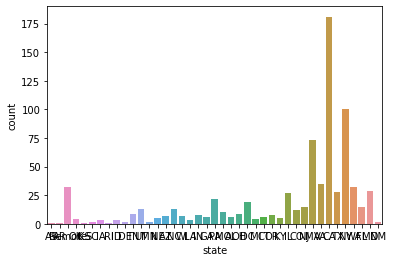

In [174]:
ax = sns.countplot(df_master['state'])
ax.invert_xaxis()